# Data loading

## Libraries import

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


PATH = '../data/transformer-time/'

## Available (Train) set

In [4]:
y_data = pd.read_csv(PATH + 'train.csv', index_col='id')
y_data.head()

,predicted
id,
2_trans_497.csv,550
2_trans_483.csv,1093
2_trans_2396.csv,861
2_trans_1847.csv,1093
2_trans_2382.csv,488


In [5]:
X_data = {}
for row in y_data.iterrows():
    file_name = row[0]
    path = PATH + f'data_train/data_train/{file_name}'
    X_data[file_name] = pd.read_csv(path)

In [6]:
X_data[file_name].shape

(420, 4)

In [16]:
X_data[file_name].head(2)

,H2,CO,C2H4,C2H2
0,0.001545,0.024891,0.002929,0.000135
1,0.001545,0.024891,0.002928,0.000135


Since we don't have y_test, all the experments will be conducted using only train set. So, we will divide train set into train and validation sets. Validation set will be used as left out test set for results evaluation.

# Modeling

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, f1_score
from catboost import CatBoostRegressor
from tsfresh.feature_extraction import extract_features, MinimalFCParameters, ComprehensiveFCParameters
from tsfresh.feature_selection import  select_features

## Baseline using mean value of RUL

In [18]:
y_train, y_val = train_test_split(y_data, test_size=0.25, random_state=1)
print(f'Train set shape: {y_train.shape}')
print(f'Test set shape: {y_val.shape}')

Train set shape: (1575, 1)
Test set shape: (525, 1)


In [8]:
y_train_pred = [y_train.mean().values[0]] * len(y_train)
y_val_pred = [y_train.mean().values[0]] * len(y_val)

In [9]:
mae_train = round(mean_absolute_error(y_train, y_train_pred), 2)
mae_val = round(mean_absolute_error(y_val, y_val_pred), 2)
print(f'MAE on train set = {mae_train}')
print(f'MAE on test set = {mae_val}')

MAE on train set = 219.97
MAE on test set = 218.38


## Regression on aggregated parameters

### Approach 1: simple aggregation + linear regression

In [ ]:
y = y_data.copy()
X = pd.concat([X_data[file].mean() for file in y_data.index], axis=1).T
X.index = y.index
X = X.add_suffix('_mean')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

StSc = StandardScaler()
X_train_sc = StSc.fit_transform(X_train)
X_val_sc = StSc.transform(X_val)

lr = LinearRegression()
lr.fit(X_train_sc, y_train)

y_train_pred = lr.predict(X_train_sc)
y_val_pred = lr.predict(X_val_sc)

mae_train = round(mean_absolute_error(y_train, y_train_pred), 2)
mae_val = round(mean_absolute_error(y_val, y_val_pred), 2)
print(f'MAE on train set = {mae_train}')
print(f'MAE on test set = {mae_val}')

### Approach 2: simple aggregation + gradient boosting

In [ ]:
y = y_data.copy()
X = pd.concat([X_data[file].mean() for file in y_data.index], axis=1).T
X.index = y.index
X = X.add_suffix('_mean')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

cbr = CatBoostRegressor(random_state=1, verbose=0)
cbr.fit(X_train, y_train)

y_train_pred = cbr.predict(X_train)
y_val_pred = cbr.predict(X_val)

mae_train = round(mean_absolute_error(y_train, y_train_pred), 2)
mae_val = round(mean_absolute_error(y_val, y_val_pred), 2)
print(f'MAE on train set = {mae_train}')
print(f'MAE on test set = {mae_val}')

### Approach 3: complex aggregation (TSFresh) + linear regression

In [ ]:
X = pd.concat([X_data[file].assign(id=file) for file in y_data.index], axis=0, ignore_index=True)
y = y_data.copy()

settings = MinimalFCParameters()
X = extract_features(X, 
                     column_id="id", 
                     default_fc_parameters=settings).loc[y.index]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

StSc = StandardScaler()
X_train_sc = StSc.fit_transform(X_train)
X_val_sc = StSc.transform(X_val)

In [ ]:
lr = LinearRegression()
lr.fit(X_train_sc, y_train)

y_train_pred = lr.predict(X_train_sc)
y_val_pred = lr.predict(X_val_sc)

mae_train = round(mean_absolute_error(y_train, y_train_pred), 2)
mae_val = round(mean_absolute_error(y_val, y_val_pred), 2)
print(f'MAE on train set = {mae_train}')
print(f'MAE on test set = {mae_val}')

### Approach 4: complex aggregation (TSFresh) + gradient boosting

In [19]:
X = pd.concat([X_data[file].assign(id=file) for file in y_data.index], axis=0, ignore_index=True)
y = y_data.copy()

settings = MinimalFCParameters()
X = extract_features(X, 
                     column_id="id", 
                     default_fc_parameters=settings).loc[y.index]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

Feature Extraction: 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


In [14]:
cbr = CatBoostRegressor(random_state=1, verbose=0)
cbr.fit(X_train, y_train)

y_train_pred = cbr.predict(X_train)
y_val_pred = cbr.predict(X_val)

mae_train = round(mean_absolute_error(y_train, y_train_pred), 2)
mae_val = round(mean_absolute_error(y_val, y_val_pred), 2)
print(f'MAE on train set = {mae_train}')
print(f'MAE on test set = {mae_val}')

MAE on train set = 37.2
MAE on test set = 91.37


The model is clearly overfitted.

### Why is the error so big?

In [ ]:
plt.figure(figsize=(6, 3))
plt.hist(y_val_pred, bins=30, alpha=0.6, label='Predicted values on the test set')
plt.hist(y_val, bins=30, alpha=0.6, label='True values of the test set')
plt.legend()
plt.show()

## Ensemble: classification + regression

### Stage 1: classification

Let's call values equal to 1093 outliers.

In [20]:
y = (y_data == 1093).astype(int)
X = pd.concat([X_data[file].assign(id=file) for file in y_data.index], axis=0, ignore_index=True)

settings = ComprehensiveFCParameters()
X = extract_features(X, 
                     column_id="id", 
                     default_fc_parameters=settings).loc[y.index]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

Feature Extraction: 100%|██████████| 10/10 [15:29<00:00, 92.99s/it]


In [37]:
X_train

,H2__variance_larger_than_standard_deviation,H2__has_duplicate_max,H2__has_duplicate_min,H2__has_duplicate,H2__sum_values,H2__abs_energy,H2__mean_abs_change,H2__mean_change,H2__mean_second_derivative_central,H2__median,...,C2H2__fourier_entropy__bins_5,C2H2__fourier_entropy__bins_10,C2H2__fourier_entropy__bins_100,C2H2__permutation_entropy__dimension_3__tau_1,C2H2__permutation_entropy__dimension_4__tau_1,C2H2__permutation_entropy__dimension_5__tau_1,C2H2__permutation_entropy__dimension_6__tau_1,C2H2__permutation_entropy__dimension_7__tau_1,C2H2__query_similarity_count__query_None__threshold_0.0,C2H2__mean_n_absolute_max__number_of_maxima_7
id,,,,,,,,,,,,,,,,,,,,,
2_trans_2001.csv,0.0,0.0,0.0,0.0,0.994863,0.002362,1.331274e-06,1.243474e-06,3.408576e-09,0.002344,...,0.090729,0.136002,0.136002,0.624938,0.655497,0.686154,0.716912,0.747770,NaN,0.000390
2_trans_2998.csv,0.0,0.0,0.0,0.0,0.720606,0.001245,1.477622e-06,1.477622e-06,5.020607e-09,0.001718,...,0.136002,0.181214,0.271451,0.751863,0.816460,0.881158,0.945955,1.014197,NaN,0.000027
2_trans_437.csv,0.0,0.0,0.0,0.0,0.233862,0.000132,1.170104e-06,4.929081e-07,4.312393e-09,0.000560,...,0.045395,0.045395,0.181214,0.118661,0.142589,0.166211,0.189443,0.212160,NaN,0.000379
2_trans_642.csv,0.0,0.0,0.0,0.0,0.328945,0.000260,1.134916e-06,8.056558e-07,1.796542e-09,0.000770,...,0.090729,0.090729,0.136002,0.608520,0.639001,0.669582,0.700261,0.731039,NaN,0.000387
2_trans_3000.csv,0.0,0.0,0.0,0.0,0.775452,0.001442,2.017160e-06,1.754019e-06,7.783435e-09,0.001854,...,0.045395,0.125256,0.136002,0.635809,0.666413,0.697117,0.727921,0.758826,NaN,0.000057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2_trans_41.csv,0.0,0.0,0.0,0.0,0.961194,0.002299,4.155758e-06,4.155758e-06,1.082169e-08,0.002131,...,0.125256,0.136002,0.181214,0.635809,0.666413,0.697117,0.727921,0.758826,NaN,0.000226
2_trans_975.csv,0.0,0.0,0.0,0.0,0.448076,0.000480,9.668378e-07,7.986838e-07,2.188927e-09,0.001063,...,0.136002,0.136002,0.136002,0.703053,0.733778,0.764604,0.795531,0.826558,NaN,0.000065
2_trans_2303.csv,0.0,0.0,0.0,0.0,0.441261,0.000497,3.329145e-06,2.687629e-06,6.575940e-09,0.000943,...,0.090729,0.136002,0.136002,0.704964,0.735684,0.766505,0.797426,0.828447,NaN,0.000226


In [36]:
X_train_filtered = select_features(X_train.dropna(axis=1), pd.Series(y_train['predicted']))
relevant_features = set(X_train_filtered.columns)

X_train_filtered = X_train[list(relevant_features)]
X_val_filtered = X_val[list(relevant_features)]

X_train_filtered

,"C2H2__fft_coefficient__attr_""real""__coeff_51","C2H4__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.4","C2H2__fft_coefficient__attr_""real""__coeff_22","CO__fft_coefficient__attr_""angle""__coeff_89","H2__fft_coefficient__attr_""abs""__coeff_58","H2__fft_coefficient__attr_""abs""__coeff_21","CO__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""min""","CO__fft_coefficient__attr_""imag""__coeff_61",C2H4__ar_coefficient__coeff_3__k_10,"C2H4__fft_coefficient__attr_""imag""__coeff_19",...,"CO__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)",C2H4__symmetry_looking__r_0.1,"C2H4__fft_coefficient__attr_""imag""__coeff_25","C2H4__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)","CO__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)","CO__fft_coefficient__attr_""abs""__coeff_51","C2H4__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)",C2H2__lempel_ziv_complexity__bins_5,"CO__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.6","CO__fft_coefficient__attr_""angle""__coeff_87"
id,,,,,,,,,,,,,,,,,,,,,
2_trans_2001.csv,-0.000076,1.753367e-06,-0.000066,127.797766,0.000622,0.001674,0.709943,0.006630,3.618489,0.004326,...,0.001976,1.0,0.003271,0.000419,0.004151,0.008701,0.000140,0.128571,1.969936e-10,126.930048
2_trans_2998.csv,-0.000008,7.463647e-07,-0.000001,-50.449042,0.000739,0.001986,-0.396254,-0.000372,-0.957440,0.001282,...,0.000461,1.0,0.000972,0.000363,0.000974,0.000501,0.000116,0.150000,2.943249e-11,-51.262047
2_trans_437.csv,-0.000025,3.602815e-07,-0.000023,127.806625,0.000247,0.000665,0.856590,0.008115,3.484438,0.000406,...,0.001508,1.0,0.000307,0.001083,0.003186,0.010649,0.000346,0.145238,1.345016e-10,126.938093
2_trans_642.csv,-0.000071,2.613900e-06,-0.000065,127.947039,0.000404,0.001087,0.850631,0.021821,2.471616,0.016747,...,0.006027,0.0,0.012657,0.008711,0.012729,0.028690,0.002743,0.130952,2.248016e-10,127.082097
2_trans_3000.csv,-0.000012,1.689256e-06,-0.000010,127.195458,0.000878,0.002359,0.412096,0.000681,-1.444416,0.001594,...,0.000154,1.0,0.001207,0.000008,0.000337,0.001097,0.000007,0.150000,1.669509e-11,132.973738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2_trans_41.csv,-0.000023,1.315060e-06,-0.000019,127.954656,0.002077,0.005582,0.962846,0.008649,3.510461,0.007937,...,0.015438,1.0,0.006004,0.006966,0.032685,0.011374,0.002203,0.133333,5.262857e-11,127.090967
2_trans_975.csv,-0.000018,3.071787e-07,-0.000014,127.811576,0.000400,0.001076,0.301402,0.004073,2.757969,0.006058,...,0.003964,1.0,0.004580,0.003229,0.008339,0.005347,0.001020,0.145238,7.059611e-11,126.944345
2_trans_2303.csv,-0.000022,1.486050e-06,-0.000022,127.968230,0.001346,0.003620,0.574719,0.006436,2.723769,0.007123,...,0.014063,0.0,0.005383,0.001727,0.029762,0.008466,0.000536,0.145238,2.848821e-10,127.106746


In [41]:
StSc = StandardScaler()
X_train_sc = StSc.fit_transform(X_train_filtered)
X_val_sc = StSc.transform(X_val_filtered)

In [73]:
 pd.Series(y_train)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
LogReg = LogisticRegression(solver='saga', multi_class='ovr', max_iter=200, verbose=0, n_jobs=-1)
LogReg.fit(pd.DataFrame(X_train_sc).dropna(axis=1).values, y_train)

y_train_pred_outliers = pd.DataFrame(LogReg.predict(X_train_sc), 
                                     index=y_train.index, 
                                     columns=y_train.columns)
y_val_pred_outliers = pd.DataFrame(LogReg.predict(X_val_sc), 
                                   index=y_val.index, 
                                   columns=y_val.columns)

f1_train = round(f1_score(y_train, y_train_pred_outliers), 2)
f1_val = round(f1_score(y_val, y_val_pred_outliers), 2)
print(f'F1 on train set = {f1_train}')
print(f'F1 on test set = {f1_val}')

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packag

### Stage 2: linear regression

In [ ]:
y = y_data.copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

y_train_wo_outliers = y_train[y_train != 1093].dropna()
X_train_wo_outliers = X_train.loc[y_train_wo_outliers.index]

StSc = StandardScaler()
X_train_wo_outliers_sc = StSc.fit_transform(X_train_wo_outliers)
X_train_sc = StSc.transform(X_train)
X_val_sc = StSc.transform(X_val)

In [ ]:
lr = LinearRegression()
lr.fit(X_train_wo_outliers_sc, y_train_wo_outliers)

y_train_pred = pd.DataFrame(lr.predict(X_train_sc), 
                            index=y_train.index, 
                            columns=y_train.columns)
y_val_pred = pd.DataFrame(lr.predict(X_val_sc), 
                          index=y_val.index, 
                          columns=y_val.columns)

In [ ]:
ind = y_train_pred_outliers[y_train_pred_outliers['predicted']==1].index
y_train_pred.loc[ind] = 1093

ind = y_val_pred_outliers[y_val_pred_outliers['predicted']==1].index
y_val_pred.loc[ind] = 1093

mae_train = round(mean_absolute_error(y_train, y_train_pred), 2)
mae_val = round(mean_absolute_error(y_val, y_val_pred), 2)
print(f'MAE on train set = {mae_train}')
print(f'MAE on test set = {mae_val}')

It is better than previous linear regression. Previous metrics:
- MAE on train set = 140.82
- MAE on test set = 148.21

### Stage 2: gradient boosting regression

In [45]:
y = y_data.copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

y_train_wo_outliers = y_train[y_train != 1093].dropna()
X_train_wo_outliers = X_train.loc[y_train_wo_outliers.index]

StSc = StandardScaler()
X_train_wo_outliers_sc = StSc.fit_transform(X_train_wo_outliers)
X_train_sc = StSc.transform(X_train)
X_val_sc = StSc.transform(X_val)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.10/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/conda/lib/python3.10/site-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [47]:
cbr = CatBoostRegressor(random_state=1, verbose=0)
cbr.fit(X_train_wo_outliers_sc, y_train_wo_outliers)

y_train_pred = pd.DataFrame(cbr.predict(X_train_sc), 
                            index=y_train.index, 
                            columns=y_train.columns)
y_val_pred = pd.DataFrame(cbr.predict(X_val_sc), 
                          index=y_val.index, 
                          columns=y_val.columns)

Learning rate set to 0.041185
0:	learn: 139.8466808	total: 293ms	remaining: 4m 52s
1:	learn: 137.1775501	total: 526ms	remaining: 4m 22s
2:	learn: 134.9267130	total: 771ms	remaining: 4m 16s
3:	learn: 132.5427424	total: 1s	remaining: 4m 9s
4:	learn: 130.5025750	total: 1.28s	remaining: 4m 14s
5:	learn: 128.2323709	total: 1.56s	remaining: 4m 18s
6:	learn: 126.1533334	total: 1.79s	remaining: 4m 14s
7:	learn: 123.9418519	total: 2.03s	remaining: 4m 11s
8:	learn: 121.8900428	total: 2.27s	remaining: 4m 9s
9:	learn: 119.9955631	total: 2.5s	remaining: 4m 7s
10:	learn: 118.3009064	total: 2.74s	remaining: 4m 6s
11:	learn: 116.4573767	total: 2.97s	remaining: 4m 4s
12:	learn: 114.7816295	total: 3.2s	remaining: 4m 2s
13:	learn: 113.1619097	total: 3.42s	remaining: 4m 1s
14:	learn: 111.5908115	total: 3.65s	remaining: 4m
15:	learn: 110.2375513	total: 3.9s	remaining: 3m 59s
16:	learn: 108.9279376	total: 4.14s	remaining: 3m 59s
17:	learn: 107.4568944	total: 4.37s	remaining: 3m 58s
18:	learn: 106.2309128	to

In [49]:
ind = y_train_pred_outliers[y_train_pred_outliers['predicted']==1].index
y_train_pred.loc[ind] = 1093

ind = y_val_pred_outliers[y_val_pred_outliers['predicted']==1].index
y_val_pred.loc[ind] = 1093

mae_train = round(mean_absolute_error(y_train, y_train_pred), 2)
mae_val = round(mean_absolute_error(y_val, y_val_pred), 2)
print(f'MAE on train set = {mae_train}')
print(f'MAE on test set = {mae_val}')

MAE on train set = 11.63
MAE on test set = 77.67


Better than linear regression but worse than previous gradboosting regression. Previous metrics:
- MAE on train set = 37.2
- MAE on test set = 91.37

We still need to deal with overfitting but for the last algorithm overfitting is much less. So, in total the last algorithm is much better.

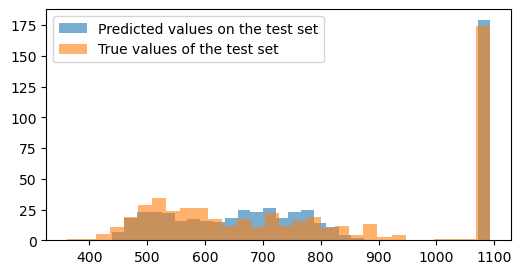

In [50]:
plt.figure(figsize=(6, 3))
plt.hist(y_val_pred, bins=30, alpha=0.6, label='Predicted values on the test set')
plt.hist(y_val, bins=30, alpha=0.6, label='True values of the test set')
plt.legend()
plt.show()